In [1]:
import numpy as np
import tensorflow.keras.layers as layers

from keras import backend as K
import keras
import tensorflow as tf


from livelossplot import PlotLossesKeras
import tensorflow as tf
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
import sklearn
from sklearn import metrics
import seaborn as sns
from scipy.interpolate import interpolate
from sklearn.feature_extraction import image
from tqdm.auto import tqdm, trange
import training_modules
import evaluation_modules

/bg/fast/env_wiegels-r/mambaforge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU avilability
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# open datasets
# patches for training and validation
patches_06 = xr.open_dataset('data/patches.nc')

# whole area of SEVIRI and lowres RADKLIM for testing
ds_seviri = xr.open_zarr('/pd/data/CML/seviri/test_wiegels/DE_06.zarr')

ds_yw = xr.open_dataset('data/ds_yw_202006')




In [5]:
#ds_pcph  = xr.open_dataset('data/ds_pcph_cut_05-06.nc') #Note: already flipped y-axis!

In [6]:
img_height = 9
img_width = 9
bi_threshold = 0.05 # (mm/15min)

# from DL_data_analysis: excludes outlier
min_temp = 202.758
max_temp = 317.1550 
min_bright = 0.000000
max_bright = 101.4570

In [8]:
#patches_06_train = patches_06.where(patches_06.times<=np.datetime64(train_frame[1]), drop=True)
ds_input_train = ds_train.input.isel(channels=slice(0, 8))
patches_VAL = ds_val.input.isel(channels=slice(0, 8))
#patches_06_train.to_netcdf("patches/patches_train_2.nc", encoding={'input': {'zlib': True}, 'target': {'zlib':True}})
#np.save('patches/patches_VAL', np.asarray(patches_VAL))


In [10]:
# train, validation and test input
ds_input_train = np.asarray(ds_input_train).reshape(ds_input_train.shape[0],9,9,8)
ds_input_val  = np.asarray(patches_VAL).reshape(patches_VAL.shape[0],9,9,8)

ds_input_test = ds_yw_sev

# y binary target input for training and validation
y_train = training_modules.create_bi_img(
    np.asarray(ds_train.target).reshape(ds_train.target.shape[0], img_height, img_width), 
    threshold=bi_threshold)
y_val = training_modules.create_bi_img(
    np.asarray(ds_val.target).reshape(ds_val.target.shape[0], img_height, img_width), 
    threshold=bi_threshold)
# target
ds_target_test = training_modules.create_bi_img(
    np.asarray(ds_yw_test.rainfall_amount), 
    threshold=bi_threshold)

In [11]:
print(ds_input_train.shape, ds_input_val.shape, y_train.shape, y_val.shape)

(1915806, 9, 9, 8) (965103, 9, 9, 8) (1915806, 9, 9) (965103, 9, 9)


(3889, 180, 252, 8)


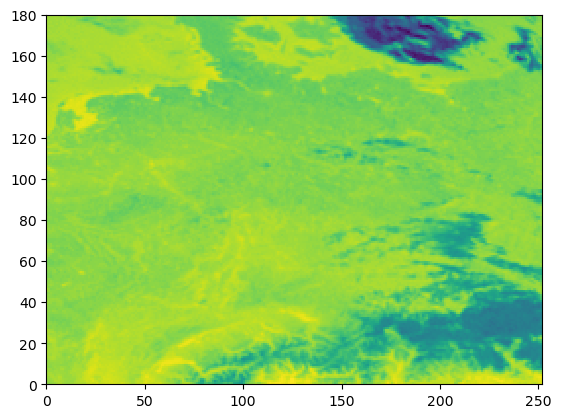

In [16]:
# Normalize input
x_train = np.asarray(training_modules.normalize_train_val(ds_input_train, min_temp = 202.758, max_temp = 317.1550 , min_bright = 0.000000, max_bright = 101.4570))
x_val = np.asarray(training_modules.normalize_train_val(ds_input_val, min_temp = 202.758, max_temp = 317.1550 , min_bright = 0.000000, max_bright = 101.4570))
x_test = np.asarray(training_modules.normalize_test(ds_input_test, min_temp = 202.758, max_temp = 317.1550 , min_bright = 0.000000, max_bright = 101.4570))

In [18]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, ds_target_test.shape)

(1915806, 9, 9, 8) (1915806, 9, 9)
(965103, 9, 9, 8) (965103, 9, 9)
(3889, 180, 252, 8) (3889, 180, 252)


In [19]:
# throw out any patch with no rain or almost no rain (e.g. only 5 pixels of binary image with rain) # low-resolution
def reduce_low_rain(img, bi_img, threshold):
    return img[np.sum(bi_img, axis=(1,2)) > threshold]
# compare rain/no-rain ratio of datasets
print('Rain/no-rain ratio (val)', (y_val==1).sum()/(y_val>=0).sum())
print('Rain/no-rain ratio (train)', (ds_target_test>=0.05).sum()/(ds_target_test>=0).sum())
#train
threshold = 0
x_train_wet = reduce_low_rain(x_train, y_train, threshold)
y_train_wet = reduce_low_rain(y_train, y_train, threshold)
#val
x_val_wet = reduce_low_rain(x_val, y_val, threshold)
y_val_wet = reduce_low_rain(y_val, y_val, threshold)

print('Rain/no-rain ratio (val)', (y_val_wet==1).sum()/(y_val_wet>=0).sum())
print('Rain/no-rain ratio (train)', (ds_target_test>=0.05).sum()/(ds_target_test>=0).sum())

Rain/no-rain ratio (test) 0.05926288214212983
Rain/no-rain ratio (val) 0.042276278244874343
Rain/no-rain ratio (train) 0.0778423354742005
Rain/no-rain ratio (test) 0.27300030341510756
Rain/no-rain ratio (val) 0.2288126862590175
Rain/no-rain ratio (train) 0.0778423354742005


In [21]:
x_val_wd, y_val_wd = training_modules.sample_set_wet_dry(0.5, x_val, x_val_wet, y_val, y_val_wet)
x_train_wd, y_train_wd = training_modules.sample_set_wet_dry(0.5, x_train, x_train_wet, y_train, y_train_wet)

In [22]:
print('VALIDATION', x_val.shape, y_val.shape, y_val_wet.shape, x_val_wd.shape, y_val_wd.shape)
print('TRAINING', x_train.shape, y_train.shape, y_train_wet.shape, x_train_wd.shape, y_train_wd.shape)

VALIDATION (965103, 9, 9, 8) (965103, 9, 9) (178316, 9, 9) (571709, 9, 9, 8) (571709, 9, 9)
TRAINING (1915806, 9, 9, 8) (1915806, 9, 9) (415883, 9, 9) (1165844, 9, 9, 8) (1165844, 9, 9)


In [23]:
print('Rain/no-rain ratio (val)', (y_val_wd==1).sum()/(y_val_wd>=0).sum())
print('Rain/no-rain ratio (train)', (y_train_wd>=0.05).sum()/(y_train_wd>=0).sum())

Rain/no-rain ratio (val) 0.09945964696837373
Rain/no-rain ratio (train) 0.13256633534732493


In [25]:
yw_test = tf.convert_to_tensor(ds_target_test, dtype=tf.int8)

2023-03-06 07:05:21.588858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 07:05:24.012365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30981 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [26]:
# Transformation to tensor for DL Model
# Train with selected share of dry patches:
y_train = y_train_wd
y_val = y_val_wd
x_train = x_train_wd
x_val = x_val_wd

y_train_low = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
y_val_low = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)
y_train_low = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_low = tf.convert_to_tensor(y_val, dtype=tf.float32)


x_train0_low, x_train1_low, x_train2_low, x_train3_low, x_train4_low, x_train5_low, x_train6_low, x_train7_low = training_modules.to_tensor(x_train)
x_val0_low, x_val1_low, x_val2_low, x_val3_low, x_val4_low, x_val5_low, x_val6_low, x_val7_low = training_modules.to_tensor(x_val)
test_0, test_1, test_2, test_3, test_4, test_5, test_6, test_7 = training_modules.to_tensor(x_test)

## MODEL

In [28]:
# Model Functions
def convbn(x, n_filter):
    x = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same',
                                     kernel_initializer=initializer,
                          )(x)
    x = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same',
                                     kernel_initializer=initializer,
                          )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x


def downsampling(x, n_filter):
    x1 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    skip = tf.keras.layers.LeakyReLU()(x1)
    y = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(skip)
    return y, skip


def Conv(x, n_filter):
        x2 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x)
        x2 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        
        return x2

    
def upsampling_skip(x, skip, up_factor, n_filter):
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same', )(x)
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same', )(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.UpSampling2D((up_factor, up_factor), interpolation='bilinear')(x3)
    y = tf.keras.layers.Concatenate()([x3, skip])
    return y

def upsampling(x, up_factor, n_filter):
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same')(x)
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.UpSampling2D((up_factor, up_factor), interpolation='bilinear')(x3)
    return x3

def channel_conv(x, n_filter_1, n_filter_2):
    x1 = tf.keras.layers.Conv2D(n_filter_1, kernel_size=3, padding='same')(x)
    x1 = tf.keras.layers.ReLU()(x1)
    x1 = tf.keras.layers.Conv2D(n_filter_2, kernel_size=3, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    #x1 = tf.keras.layers.Dropout(0.3)(x1)
    x1 = tf.keras.layers.ReLU()(x1)
    return x1

In [29]:
# CNN Model
input_shape = [None, None, 1]
input_1 = tf.keras.layers.Input(shape=input_shape)
input_2 = tf.keras.layers.Input(shape=input_shape)
input_3 = tf.keras.layers.Input(shape=input_shape)
input_4 = tf.keras.layers.Input(shape=input_shape)
#input_5 = tf.keras.layers.Input(shape=[None, None, 1])
#input_6 = tf.keras.layers.Input(shape=[None, None, 1])
#input_7 = tf.keras.layers.Input(shape=[None, None, 1])
#input_8 = tf.keras.layers.Input(shape=[None, None, 1])
initializer = tf.keras.initializers.GlorotNormal()

#Downsampling per channel
x1 = channel_conv(input_1, 32, 64)
x1_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x1)

x2 = channel_conv(input_2,  32, 64)
x2_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x2)

x3 = channel_conv(input_3, 32, 64)
x3_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x3)

x4 = channel_conv(input_4, 32, 64)
x4_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x4)

# define number
xs = [x1, x2, x3, x4]
x_lows = [x1_low, x2_low, x3_low, x4_low]
inputs = [input_1, input_2, input_3, input_4]

# Concatenation each
x = tf.keras.layers.Concatenate()(xs)
x_low = tf.keras.layers.Concatenate()(x_lows)

# Upsampling
x_low = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=(3, 3),
                                       )(x_low)

# Concatenation of pooled and un-pooled layer
x = tf.keras.layers.Concatenate()([x, x_low])

x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

last = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=last)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, None,  0                                            
______________________________________________________________________________________________

In [30]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

BATCH_SIZE = 128

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-6,
    decay_steps=10000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

loss = ['binary_crossentropy']

METRICS = [
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    functions.get_f1,
    functions.matthews_correlation,
    functions.false_neg_rate,
    functions.true_neg_rate,
    tf.keras.metrics.MeanSquaredError(name='mse')]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["MSE"]
            )
        )
model.compile(loss=loss, optimizer=opt, metrics=METRICS)

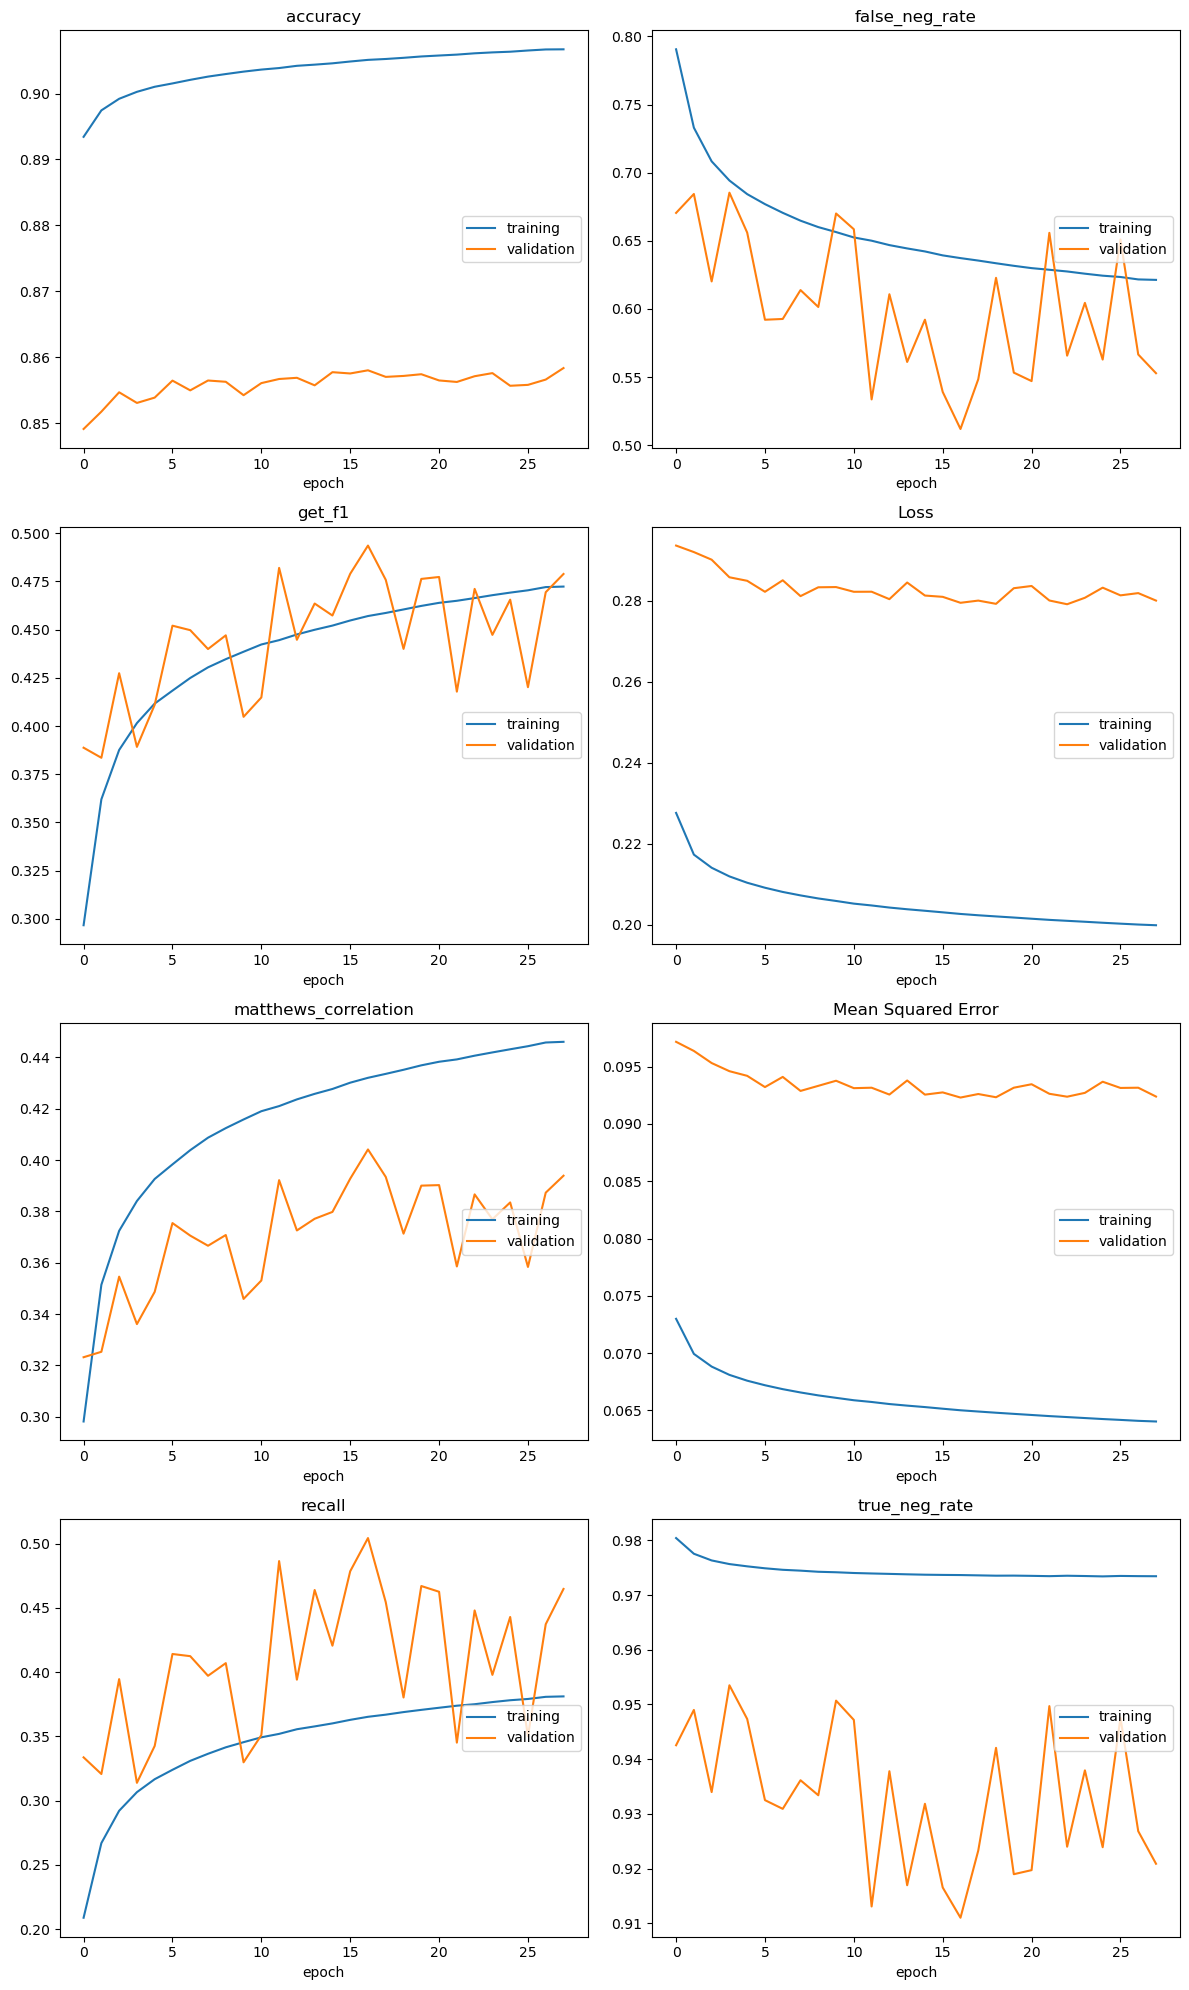

accuracy
	training         	 (min:    0.893, max:    0.907, cur:    0.907)
	validation       	 (min:    0.849, max:    0.858, cur:    0.858)
false_neg_rate
	training         	 (min:    0.621, max:    0.791, cur:    0.621)
	validation       	 (min:    0.512, max:    0.685, cur:    0.553)
get_f1
	training         	 (min:    0.297, max:    0.472, cur:    0.472)
	validation       	 (min:    0.384, max:    0.494, cur:    0.479)
Loss
	training         	 (min:    0.200, max:    0.228, cur:    0.200)
	validation       	 (min:    0.279, max:    0.294, cur:    0.280)
matthews_correlation
	training         	 (min:    0.298, max:    0.446, cur:    0.446)
	validation       	 (min:    0.323, max:    0.404, cur:    0.394)
Mean Squared Error
	training         	 (min:    0.064, max:    0.073, cur:    0.064)
	validation       	 (min:    0.092, max:    0.097, cur:    0.092)
recall
	training         	 (min:    0.209, max:    0.381, cur:    0.381)
	validation       	 (min:    0.314, max:    0.504, cur:    

In [31]:
%%time
n_samples = int(len(x_train)/BATCH_SIZE)*BATCH_SIZE
print(n_samples, len(x_train1_low))
#1: IR039, 3: IR108, 5: VIS006, 6: WV62
hist = model.fit(x = [x_train1_low[:n_samples], x_train3_low[:n_samples],  x_train5_low[:n_samples], x_train6_low[:n_samples]] , y = y_train_low[:n_samples],
          validation_data=([x_val1_low, x_val3_low, x_val5_low, x_val6_low], y_val_low),
                 batch_size=BATCH_SIZE, epochs=100,
                 shuffle=True,
                 verbose='auto',
                 callbacks=[early_stopping,
                     model_checkpoint_callback, 
                     PlotLossesKeras()
                    ])

In [32]:
# Save Model?
model.save("model/model_2020_Split3_dryshare0.5")

2023-02-23 14:58:39.710965: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/model_2020_Split3_dryshare0.5/assets


In [28]:
# from tensorflow import keras
model = keras.models.load_model("model/model_2020_dryshare0.5", custom_objects = {'binary_crossentropy': tf.keras.metrics.binary_crossentropy, 'recall':tf.keras.metrics.Recall, 
                                                                          'accuracy': tf.keras.metrics.BinaryAccuracy, 'get_f1': functions.get_f1, 'matthews_correlation': functions.matthews_correlation,
                                                                          'false_neg_rate': functions.false_neg_rate,'true_neg_rate': functions.true_neg_rate, 'mse': tf.keras.metrics.MeanSquaredError})

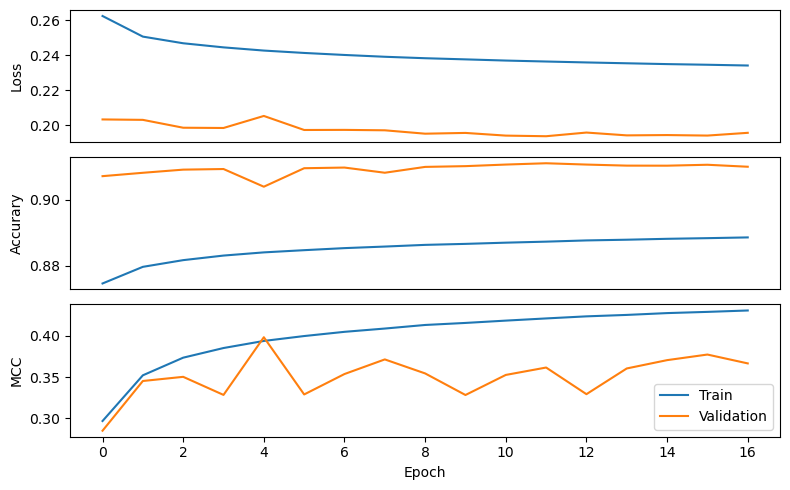

In [33]:
# summarize history for loss
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(8,5))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_ylabel('Loss')

# Acc
ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].set_ylabel('Accurary')

# MCC
ax[2].plot(hist.history['matthews_correlation'])
ax[2].plot(hist.history['val_matthews_correlation'])
ax[2].set_ylabel('MCC')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Train', 'Validation'], loc='lower right')

#Figure adjustments
for j in range(0,2):
    ax[j].tick_params('both', labelbottom=False, bottom=False)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.tight_layout()
plt.show()

In [34]:
# Save Figure?
#fig.savefig('images/DL_training_curves.png', bbox_inches='tight')

In [29]:
BATCH_SIZE=128
#x_pred_val_low = model.predict([x_val1_low, x_val3_low, x_val5_low, x_val6_low], batch_size=BATCH_SIZE)

#x_pred_train_low = model.predict([x_train1_low, x_train3_low, x_train5_low, 
#                                  x_train6_low], batch_size=BATCH_SIZE)



In [30]:
test_prediction = model.predict([test_1, test_3, test_5, test_6], batch_size=64)

2023-03-06 07:06:53.058294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-06 07:06:55.415283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401
2023-03-06 07:07:00.903112: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-03-06 07:07:00.957443: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-03-06 07:07:00.994926: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

In [32]:
#Calculate scores for test data
pred_bi = functions.create_bi_img(test_prediction, threshold=0.3)
diff = np.asarray(pred_bi).reshape(pred_bi.shape[0], pred_bi.shape[1], pred_bi.shape[2])-np.asarray(yw_test).reshape(yw_test.shape[0], yw_test.shape[1], yw_test.shape[2])

# Print Scores
#brsc_test = brier_score(yw_test, test_prediction)
#print('BrSc Test whole area', brsc_test)
yw_th_1 = 0.05
# throw out any nans

yw_arr = np.asarray(ds_yw_test.rainfall_amount.values)
yw_bi_1 = functions.create_bi_img(yw_arr, threshold=yw_th_1)
yw_test_flat = np.asarray(yw_test).flatten()
yw_bi_1_flat = yw_bi_1.flatten()
yw_test_clean = yw_test_flat[~np.isnan(yw_bi_1_flat)]
pred_bi_clean = pred_bi.flatten()[~np.isnan(yw_bi_1_flat)]
# calculate scores
oa, mcc, sens, spec, tn, fp, fn, tp = functions.confusion_matrix(y_pred=pred_bi_clean, y_true=yw_test_clean)
mse = sklearn.metrics.mean_squared_error(y_true=yw_test_clean, y_pred= pred_bi_clean)
df_results = pd.DataFrame({'threshold': [0.05] , 'acc': [oa], 'mcc': [mcc], 'sens': [sens], 'spec': [spec], 'mse':[mse],
                                   'TP (k)': [int(tp/1000)], 'FP(k)': [int(fp/1000)], 'FN(k)': [int(fn/1000)], 'TN(k)': [int(tn/1000)]})
df_results

,threshold,acc,mcc,sens,spec,mse,TP (k),FP(k),FN(k),TN(k)
0,0.05,0.901884,0.492752,0.696784,0.919197,0.098116,5282,7256,2298,82548


In [33]:
def mcc_over_time(y_true, y_pred):
    mcc_over_time = []
    for i in tqdm(range(0, y_true.shape[0])):
        true_flat = y_true[i].flatten()
        pred_flat = y_pred[i].flatten()
        true_clean = true_flat[~np.isnan(true_flat)]
        pred_clean = pred_flat[~np.isnan(true_flat)]
        mcc = metrics.matthews_corrcoef(true_clean, pred_clean)
        mcc_over_time.append(mcc)
    mcc_over_time = np.asarray(mcc_over_time)
    return mcc_over_time


In [34]:
mcc_time = functions.mcc_over_time(y_true=yw_bi_1, y_pred=pred_bi)

100%|██████████████████████████████████████████████████████████████████████████████| 3889/3889 [00:22<00:00, 175.35it/s]


In [45]:
mcc_time.shape

(3365,)

In [56]:
ds_yw_test.time.values

array(['2020-06-23T00:15:00.000000000', '2020-06-23T00:30:00.000000000',
       '2020-06-23T00:45:00.000000000', ...,
       '2020-10-31T11:45:00.000000000', '2020-10-31T12:00:00.000000000',
       '2020-10-31T12:15:00.000000000'], dtype='datetime64[ns]')

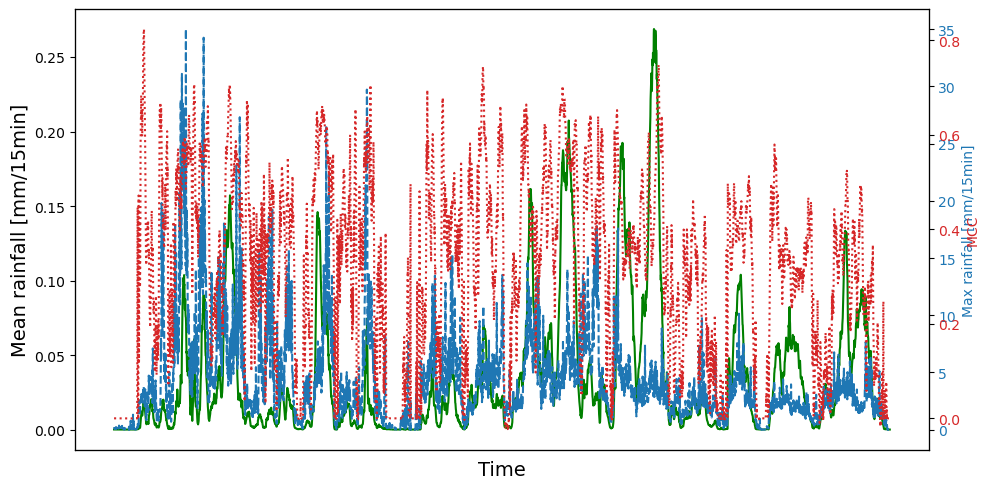

In [62]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))

ax.plot(range(0,len(ds_yw_test.time.values)), ds_yw_test.rainfall_amount.mean(dim=('x', 'y')), 'g')
ax.set_ylabel('Mean rainfall [mm/15min]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_xticks([], labels=None)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Max rainfall [mm/15min]', color=color)  # we already handled the x-label with ax1
ax2.plot(range(0,len(ds_yw_test.time.values)), ds_yw_test.rainfall_amount.max(dim=('x', 'y')), color=color, ls='--')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color3 = 'tab:red'
ax3.set_ylabel('MCC', color=color3)  # we already handled the x-label with ax1
ax3.plot(range(0,len(ds_yw_test.time.values)), mcc_time, color=color3, ls=':')
ax3.tick_params(axis='y', labelcolor=color3)

fig.tight_layout() 

plt.show()

2020-08-27T19:45:00.000000000


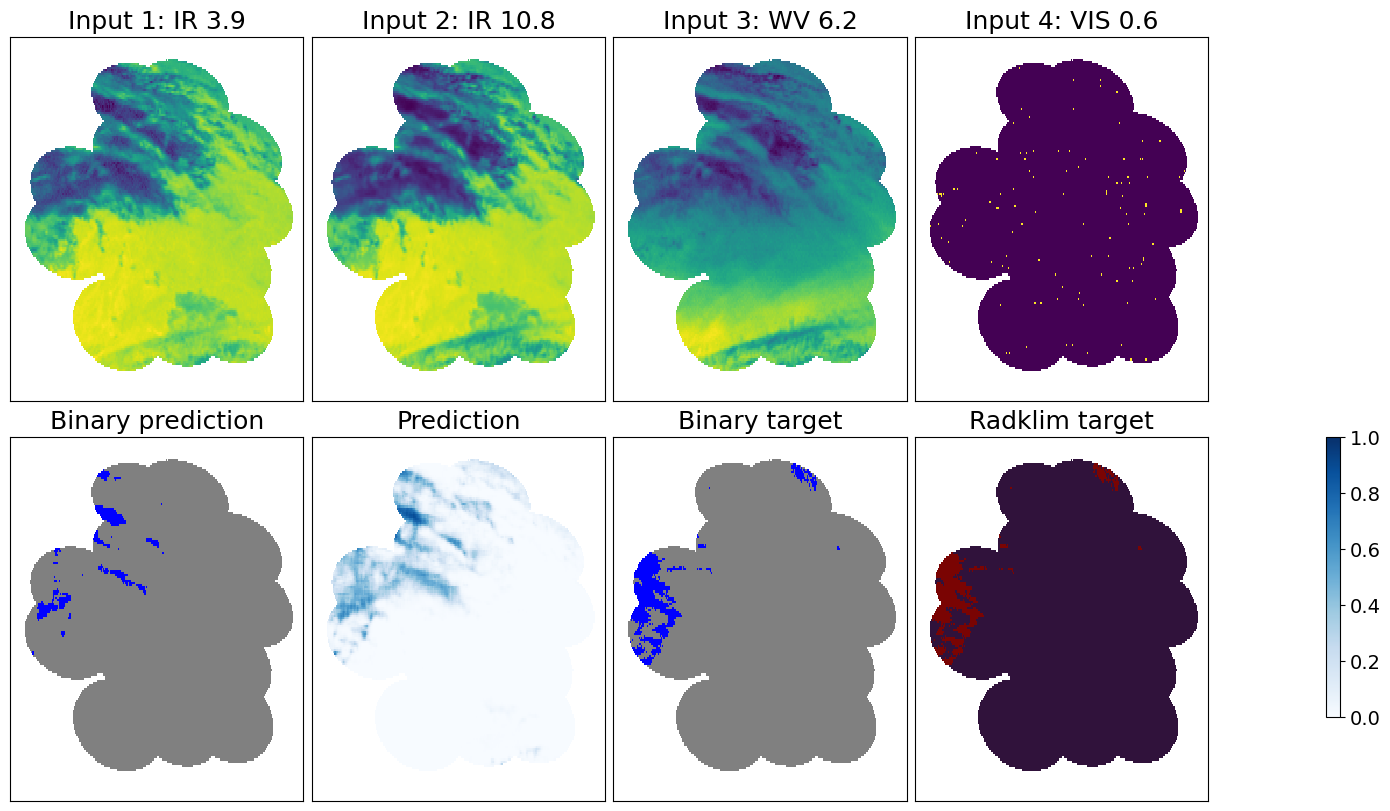

In [38]:
# check out results of test area
import matplotlib.colors as colors


cmap_bi = (colors.ListedColormap(['grey', 'blue']))
cmap_diff = (colors.ListedColormap(['red', 'green', 'blue']))
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8), constrained_layout=True)
i = 2000

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[i]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values
# Input Channels
ax[0,0].pcolormesh(mask_img(np.asarray(test_1[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,1].pcolormesh(mask_img(np.asarray(test_3[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,2].pcolormesh(mask_img(np.asarray(test_6[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,3].pcolormesh(mask_img(np.asarray(test_5[i]).reshape(np.asarray(test_5[i]).shape[0], np.asarray(test_5[i]).shape[1])))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[0,2].set_title('Input 3: WV 6.2', fontsize=18)
ax[0,3].set_title('Input 4: VIS 0.6', fontsize=18)

# Predictions
ax[1,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
im1 = ax[1,1].pcolormesh(mask_img(test_prediction[i].reshape(test_prediction.shape[1], test_prediction.shape[2])), vmin=0, vmax=1, cmap='Blues')
# RADLKLIM Target
ax[1,2].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
im = ax[1,3].pcolormesh(ds_target_test[i], cmap='turbo')

#im2 = ax[4].pcolormesh(np.asarray(diff[i]).reshape(diff.shape[1], diff.shape[2]), vmin=-1, vmax=1, cmap=cmap_diff)
ax[1,0].set_title('Binary prediction', fontsize=18)
ax[1,1].set_title('Prediction', fontsize=18)
ax[1,2].set_title('Binary target', fontsize=18)
ax[1,3].set_title('Radklim target', fontsize=18)


#ax[4].set_title('Difference', fontsize=18)
#ax[5].pcolormesh(np.asarray(test_0618_6[i]).reshape(test_0618_6.shape[1], test_0618_6.shape[2]))
cbar1 = plt.colorbar(im1, ax=ax[1,4])
#cbar1.set_label('[%]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
# cbar = plt.colorbar(im,ax=ax[1,4])
# cbar.set_label('[mm/15min]', fontsize=14)
# cbar.ax.tick_params(labelsize=14)
# cbar2 = plt.colorbar(im2, ticks=[-1, 0, 1], cmap=cmap_diff,
#     ax=ax[4],
#     extend='both',
#     spacing='proportional')
# cbar2.ax.set_yticklabels(['FN', 'TP/TN', 'FP'], fontsize=14)
print(timestep)
fig.delaxes(ax.flatten()[4])
fig.delaxes(ax.flatten()[9])
for i in range(0, 4):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)
#plt.subplots_adjust(wspace=0.0,hspace=0.0)
#plt.tight_layout()
plt.show()

In [37]:
#check out validation patches
x_pred_bi_low = functions.create_bi_img(x_pred_train_low, threshold=0.2)
x_diff_low = np.asarray(x_pred_bi_low).reshape(x_pred_bi_low.shape[0], 9, 9)-np.asarray(y_train_low).reshape(y_train_low.shape[0], 9, 9)

import matplotlib.colors as colors
cmap = 'rainbow'
cmap_diff = (colors.ListedColormap(['red', 'green', 'blue']))
cmap_bi = (colors.ListedColormap(['grey', 'blue']))
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), constrained_layout=True)
i = 234
#i=200 ## good example

#i = 10 # good prediction
#i = 35243 # good prediction
#i = 325 # bad prediction, missing small event
#i= 4734 # high probabilities, for a patch with almost all =1

im = ax[0,0].pcolormesh(np.asarray(x_train1_low[i]).reshape(9, 9), cmap='Reds')
im = ax[0,1].pcolormesh(np.asarray(x_train3_low[i]).reshape(9, 9), cmap='Reds')
im = ax[0,2].pcolormesh(np.asarray(x_train6_low[i]).reshape(9, 9), cmap='Reds')
im5 = ax[0,3].pcolormesh(np.asarray(x_train5_low[i]).reshape(9, 9))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[0,2].set_title('Input 3: WV 6.2', fontsize=18)
ax[0,3].set_title('Input 4: VIS 0.6', fontsize=18)

im_bi = ax[1,1].pcolormesh(x_pred_bi_low[i].reshape(9, 9), vmin=0, vmax=1, cmap=cmap_bi)
im1 = ax[1,2].pcolormesh(x_pred_train_low[i].reshape(9, 9), vmin=0, vmax=1)
im_bi = ax[1,3].pcolormesh(np.asarray(y_train_low[i]).reshape(9, 9), vmin=0, vmax=1, cmap=cmap_bi)
#im = ax[1,3].pcolormesh(target_train_low[i])
#im2 = ax[4].pcolormesh(np.asarray(x_diff_low[i]).reshape(9, 9), vmin=-1, vmax=1, cmap=cmap_diff)
ax[1,1].set_title('Binary prediction', fontsize=18)
ax[1,2].set_title('Prediction', fontsize=18)
ax[1,3].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)
#ax[4].set_title('Difference', fontsize=18)
# Cbars
cbar = plt.colorbar(im, ax=ax[0,2])
cbar.set_label('[K]', fontsize=14)
cbar5 = plt.colorbar(im5, ax=ax[0,3])
cbar5.set_label('[%]', fontsize=14)
cbar1 = plt.colorbar(im1, ax=ax[1,2])
cbar1.set_label('[%]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar_bi = plt.colorbar(im_bi, ticks=[0.25, 0.75], cmap=cmap_bi,
                     ax=ax[1,3], spacing='proportional')
cbar_bi.ax.set_yticklabels(['Dry', 'Wet'], fontsize=14)
#print(ds_input_train.sel(ID=i).times)
for i in range(0, 4):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False,left=False, bottom=False, labelbottom=False)
fig.delaxes(ax.flatten()[4]) # makes it possible to leave a blank space in a row/column

plt.show()

NameError: name 'x_pred_train_low' is not defined

In [40]:
x_pred_bi_low_val = functions.create_bi_img(x_pred_val_low, threshold=0.5)
x_diff_low_val = np.asarray(x_pred_bi_low_val).reshape(x_pred_bi_low_val.shape[0], 9, 9)-np.asarray(y_val_low).reshape(y_val_low.shape[0], 9, 9)
#x_diff_low_val = np.asarray(x_pred_bi_low_val).reshape(x_pred_bi_low_val.shape[0], 9, 9)-np.asarray(y_test_low).reshape(y_test_low.shape[0], 9, 9)

import matplotlib.colors as colors
import matplotlib as mpl
#cmap = 'rainbow'
cmap_diff = (colors.ListedColormap(['red', 'green', 'blue']))
bounds = [ -1.5, -0.5, 0.5, 1.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap_diff.N)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), constrained_layout=True)
i=24 # dry one
#i= 253 # dry one


ax[0,0].pcolormesh(np.asarray(x_val1_low[i]).reshape(9, 9))
ax[0,1].pcolormesh(np.asarray(x_val3_low[i]).reshape(9, 9))
ax[0,2].pcolormesh(np.asarray(x_val6_low[i]).reshape(9, 9))
ax[0,3].pcolormesh(np.asarray(x_val5_low[i]).reshape(9, 9))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[0,2].set_title('Input 3: WV 6.2', fontsize=18)
ax[0,3].set_title('Input 4: VIS 0.6', fontsize=18)

ax[1,2].pcolormesh(np.asarray(x_pred_bi_low_val[i]).reshape(9, 9), vmin=0, vmax=1)
im1 = ax[1, 3].pcolormesh(np.asarray(x_pred_val_low[i]).reshape(9, 9), vmin=0, vmax=1)
ax[1, 1].pcolormesh(np.asarray(y_val_low[i]).reshape(9, 9), vmin=0, vmax=1)
#im = ax[1, 3].pcolormesh(target_val_low[i])
# ax[2].pcolormesh(np.asarray(y_test_low[i]).reshape(9, 9), vmin=0, vmax=1)
# im = ax[3].pcolormesh(target_test_low[i])
#im2 = ax[4].pcolormesh(np.asarray(x_diff_low_val[i]).reshape(9, 9), vmin=-1, vmax=1, cmap=cmap_diff)
ax[1,2].set_title('Binary prediction', fontsize=18)
ax[1,3].set_title('Prediction', fontsize=18)
ax[1,1].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)
# ax[4].set_title('Difference', fontsize=18)
cbar1 = plt.colorbar(im1, ax=ax[1,3])
cbar1.set_label('[%]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
#cbar = plt.colorbar(im,ax=ax[1,3])
#cbar.set_label('[mm/15min]', fontsize=14)
#cbar.ax.tick_params(labelsize=14)
# cbar2 = plt.colorbar(im2, ticks=[-1, 0, 1], cmap=cmap_diff,
#     #mpl.cm.ScalarMappable(cmap=cmap_diff, norm=norm),
#     ax=ax[4],
#     #extend='both',
#     spacing='proportional',
#     #label='Discrete intervals, some other units',
# )
#cbar2.ax.set_yticklabels(['FN', 'TP/TN', 'FP'])
#print(ds_input_val.sel(ID=i).times)
for i in range(0, 4):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False, left=False, bottom=False, labelbottom=False)
fig.delaxes(ax.flatten()[4])

plt.show()

NameError: name 'x_pred_val_low' is not defined

## Results for Thesis

2020-06-28T15:15:00.000000000


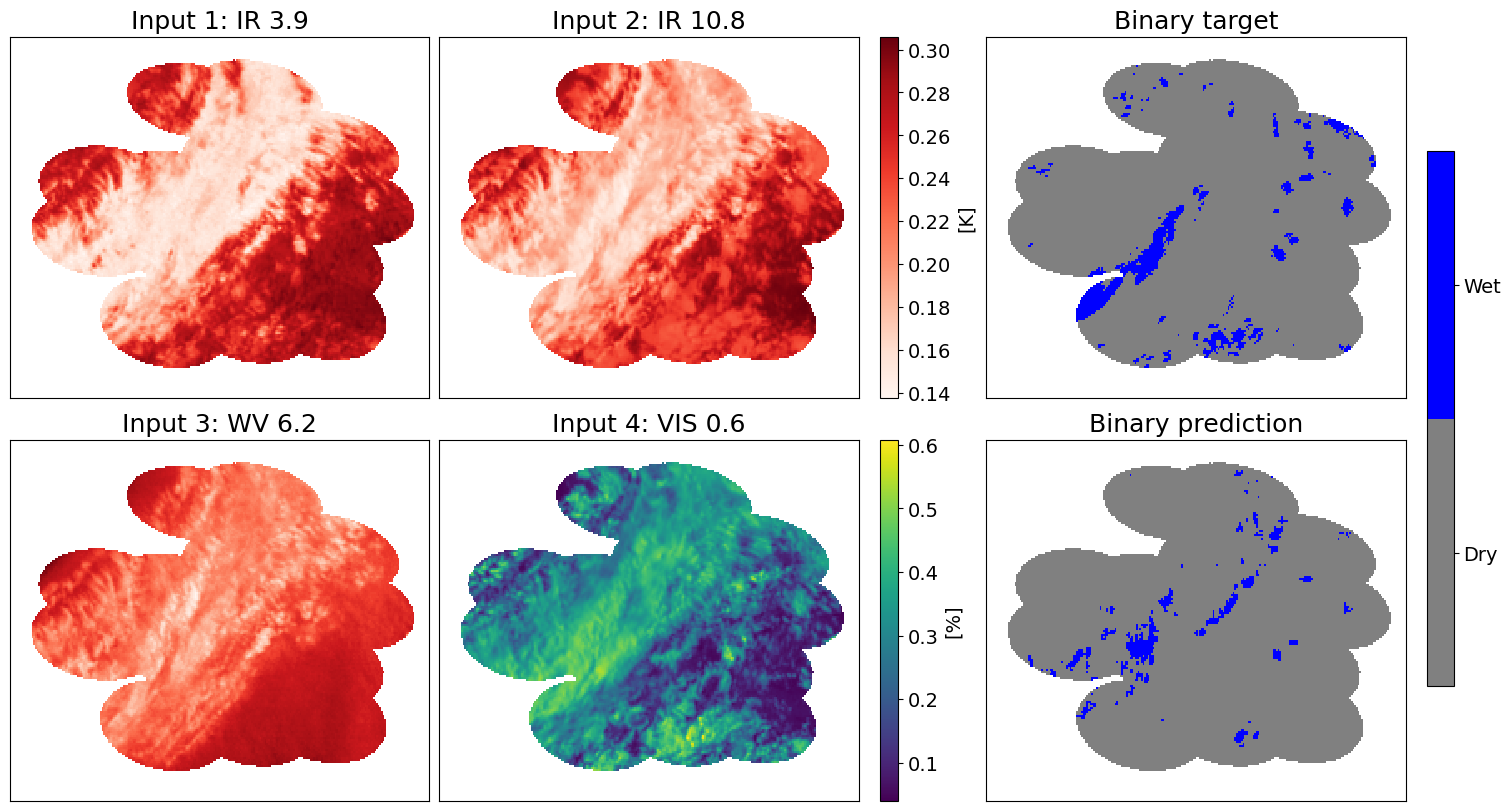

In [39]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_bi = (colors.ListedColormap(['grey', 'blue']))
cmap_diff = (colors.ListedColormap(['grey', 'red', 'cyan']))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
#i = 0 #--> selected for night bias in area and issue with scattered rainfall
i = 540
#i=350# --> good day example?
#i= 250 # --> good day example?

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[10]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values
# Input Channels
im = ax[0,0].pcolormesh(mask_img(np.asarray(test_1[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im = ax[0,1].pcolormesh(mask_img(np.asarray(test_3[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im = ax[1,0].pcolormesh(mask_img(np.asarray(test_6[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im5 = ax[1,1].pcolormesh(mask_img(np.asarray(test_5[i]).reshape(np.asarray(test_5[i]).shape[0], np.asarray(test_5[i]).shape[1])))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[1,0].set_title('Input 3: WV 6.2', fontsize=18)
ax[1,1].set_title('Input 4: VIS 0.6', fontsize=18)

# Predictions
im_bi = ax[1,2].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)

#im1 = ax[2,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])+np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=2, cmap=cmap_diff)
# RADLKLIM Target
im_bi = ax[0,2].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
#im = ax[1,3].pcolormesh(np.asarray(ds_target_test.values)[i], cmap='turbo')

# title
ax[1,2].set_title('Binary prediction', fontsize=18)
#ax[1,0].set_title('Prediction', fontsize=18)
ax[0,2].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)


print(timestep)


for i in range(0, 3):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)
#plt.subplots_adjust(wspace=0.0,hspace=0.0)
#plt.tight_layout()
#cbar
cbar = plt.colorbar(im_bi, ticks=[0.25, 0.75], cmap=cmap_bi,
                     ax=ax[:2,2], spacing='proportional', shrink=0.7)
cbar.ax.set_yticklabels(['Dry', 'Wet'], fontsize=14)
cbar = plt.colorbar(im, ax=ax[0,1])
cbar.set_label('[K]', fontsize=14,)
cbar.ax.tick_params(  labelsize=14)
cbar5 = plt.colorbar(im5, ax=ax[1,1])
cbar5.set_label('[%]', fontsize=14)
cbar5.ax.tick_params( labelsize=14)
plt.show()

In [40]:
# Save Figure?
#fig.savefig('images/DL_in_out.png', bbox_inches='tight')

In [41]:
ds_target_test.shape

(3889, 180, 252)

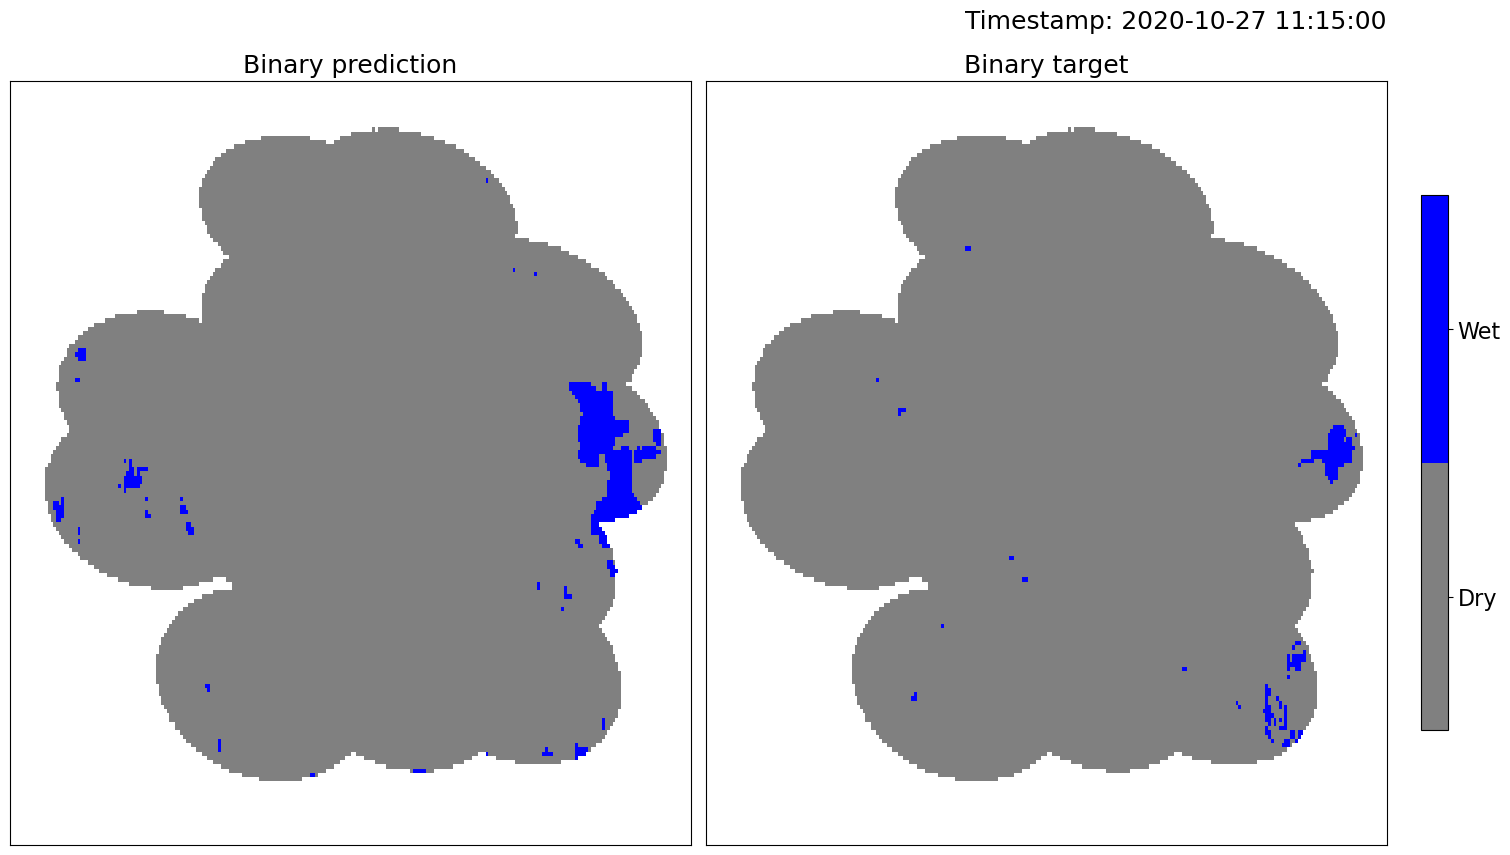

In [26]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_bi = (colors.ListedColormap(['grey', 'blue']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
i=3500
#i = 3880 # all dry correct example
#i= 3800 # example where it's quite wrong

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[100]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values

# Predictions
im_bi = ax[0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
#im1 = ax[2,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])+np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=2, cmap=cmap_diff)
# RADLKLIM Target
im_bi = ax[1].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)

fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=18, x=0.78, y=1.05)
# title
ax[0].set_title('Binary prediction', fontsize=18)
#ax[1,0].set_title('Prediction', fontsize=18)
ax[1].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)

for i in range(0, 2):
    ax[i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)

cbar = plt.colorbar(im_bi, ticks=[0.25, 0.75], cmap=cmap_bi,
                     ax=ax[1], spacing='proportional', shrink=0.7)
cbar.ax.set_yticklabels(['Dry', 'Wet'], fontsize=16)

plt.show()

In [960]:
# Save Figure?
#fig.savefig('images/gif_wetdry/080.png', bbox_inches='tight')

2020-10-30T14:15:00.000000000


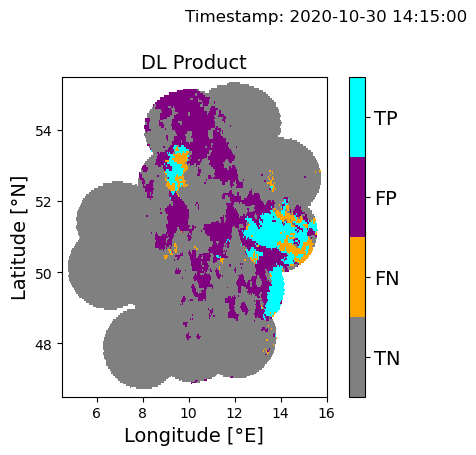

In [27]:
i = 3800


timestep = ds_input_test.isel(time=i).time.values
print(timestep)
pred_arr = np.asarray(pred_bi[i]).reshape(pred_bi.shape[1], pred_bi.shape[2])
target_img = np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])

cmap_diff = (colors.ListedColormap(['grey', 'orange', 'purple', 'cyan']))

# mask
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)

# define TN/TP/FN/FP
def tfpn_img(pred_img, target_img):
    pred_target_tp = np.where(np.logical_and(pred_img==1, target_img==1), 4, np.nan)
    pred_target_fp = np.where(np.logical_and(pred_img==1, target_img==0), 3, np.nan)
    pred_target_fn = np.where(np.logical_and(pred_img==0, target_img==1), 2, np.nan)
    pred_target_tn = np.where(np.logical_and(pred_img==0, target_img==0), 1, np.nan)
    return pred_target_tp, pred_target_fp, pred_target_fn, pred_target_tn

pred_tp, pred_fp, pred_fn, pred_tn = tfpn_img(pred_arr, target_img)



# display all in one image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), constrained_layout=True)
#prediction
im = ax.pcolormesh(ds_yw.LON.values, ds_yw.LAT.values, mask_img(pred_tp), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_yw.LON.values, ds_yw.LAT.values, mask_img(pred_fp), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_yw.LON.values, ds_yw.LAT.values, mask_img(pred_fn), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_yw.LON.values, ds_yw.LAT.values, mask_img(pred_tn), cmap=cmap_diff, vmin=1, vmax=4)
fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=12, x=0.8, y=1.1)

# title
ax.set_title('DL Product', fontsize=14)

fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=12, x=0.8, y=1.1)
# axis settings
xticks = np.arange(4, 18, 2)
yticks = np.arange(46, 58, 2)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel('Longitude [°E]', fontsize=14)
ax.set_xlim(4.5, 16)
ax.set_ylim(46.5, 55.5)
ax.set_ylabel('Latitude [°N]', fontsize=14)

#cbar
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4], cmap=cmap_diff,
                     ax=ax, values=[1,2,3,4])
cbar.ax.set_yticklabels(['TN', 'FN', 'FP', 'TP'], fontsize=14)
plt.show()

In [782]:
# Save Figure?
#fig.savefig('images/gif26/0025.png', bbox_inches='tight')

In [141]:
abs_max = max(abs(ds_target_test.isel(time=i).min()), abs(ds_target_test.isel(time=i).max()))
abs_max

<xarray.DataArray 'rainfall_amount' ()>
array(16.75228171)
Coordinates:
    time     datetime64[ns] 2021-06-29T15:15:00